# Toronto Safe Routing Network Analytics - Use Cases


### Dependencies

In [ ]:
!sudo apt install libspatialindex-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 14 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 1s (444 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.

In [ ]:
!wget https://github.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/blob/main/accident.py?raw=true
!mv accident.py\?raw\=true accident.py

--2020-12-20 17:06:05--  https://github.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/blob/main/accident.py?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/raw/main/accident.py [following]
--2020-12-20 17:06:05--  https://github.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/raw/main/accident.py
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/main/accident.py [following]
--2020-12-20 17:06:06--  https://raw.githubusercontent.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/main/accident.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.co

In [ ]:
!wget https://github.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/blob/main/graph_generator.py?raw=true
!mv graph_generator.py\?raw\=true graph_generator.py

--2020-12-20 17:06:06--  https://github.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/blob/main/graph_generator.py?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/raw/main/graph_generator.py [following]
--2020-12-20 17:06:06--  https://github.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/raw/main/graph_generator.py
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/main/graph_generator.py [following]
--2020-12-20 17:06:06--  https://raw.githubusercontent.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/main/graph_generator.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Con

In [ ]:
!wget https://github.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/blob/main/graph_analytics.py?raw=true
!mv graph_analytics.py\?raw\=true graph_analytics.py

--2020-12-20 17:06:07--  https://github.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/blob/main/graph_analytics.py?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/raw/main/graph_analytics.py [following]
--2020-12-20 17:06:07--  https://github.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/raw/main/graph_analytics.py
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/main/graph_analytics.py [following]
--2020-12-20 17:06:07--  https://raw.githubusercontent.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/main/graph_analytics.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Con

In [ ]:
pip install osmnx

     |████████████████████████████████| 92kB 5.8MB/s 
     |████████████████████████████████| 972kB 6.3MB/s 
     |████████████████████████████████| 61kB 853kB/s 
     |████████████████████████████████| 51kB 5.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.5MB 16.2MB/s 
     |████████████████████████████████| 11.6MB 45.7MB/s 
     |████████████████████████████████| 14.8MB 351kB/s 
  Created wheel for Rtree: filename=Rtree-0.9.5-cp36-cp36m-linux_x86_64.whl size=22573 sha256=fcb0298cd5dbb02e841b196b32f1927cedaa3003af8a5a86790489322a168389
  Stored in directory: /root/.cache/pip/wheels/94/2f/91/43fc12793530a37d764a794277edb9d63d77ac331067ffc583
Successfully built Rtree
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.

In [ ]:
import osmnx as ox
import networkx as nx
import graph_generator as graph_gen
import graph_analytics as glytics
import itertools

In [ ]:
G = graph_gen.create_tor_graph()

In [ ]:
G.nodes[list(G.nodes)[10]]

{'accident_list': [ACCIDENT(acc_id='1126375', year=2009, time='2315', visibility='Clear', light='Dark', road_conditions='Dry', fatalities=2, inj_index=1.0),
  ACCIDENT(acc_id='1338878', year=2012, time='611', visibility='Rain', light='Dark', road_conditions='Wet', fatalities=2, inj_index=1.0),
  ACCIDENT(acc_id='6001623474', year=2016, time='1830', visibility='Clear', light='Daylight', road_conditions='Dry', fatalities=2, inj_index=1.0)],
 'highway': 'traffic_signals',
 'osmid': 1498018,
 'x': -79.346419,
 'y': 43.7695744}

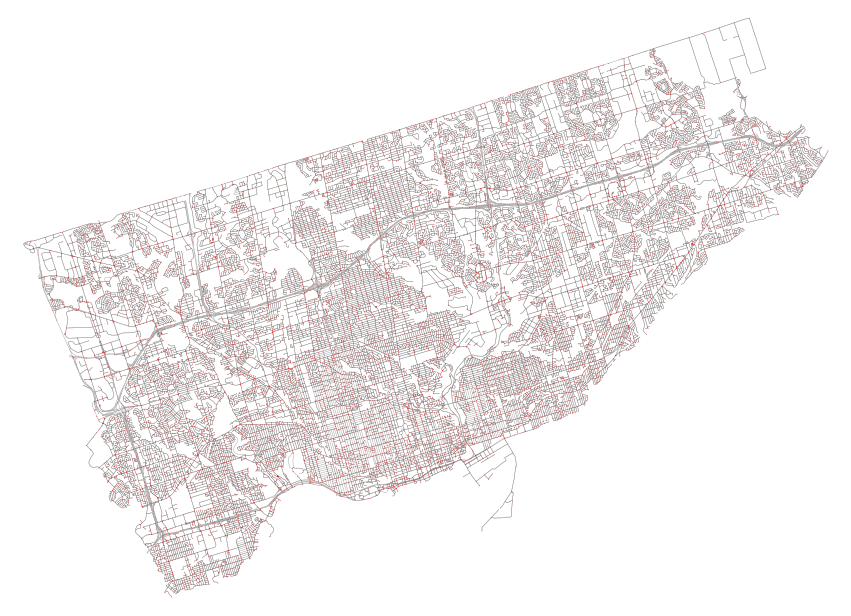

(<Figure size 1080x1080 with 1 Axes>, <AxesSubplot:>)

In [ ]:
glytics.plot_graph(G)

## PageRank

In [ ]:
glytics.pagerank_top_n(G, 10)

,PageRank Score
21421640,0.000127
32424739,0.000126
32424740,0.000125
29657708,0.000124
85942894,0.000122
32499036,0.000122
430599203,0.000120
32412371,0.000119
32755967,0.000119
4392687493,0.000119


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


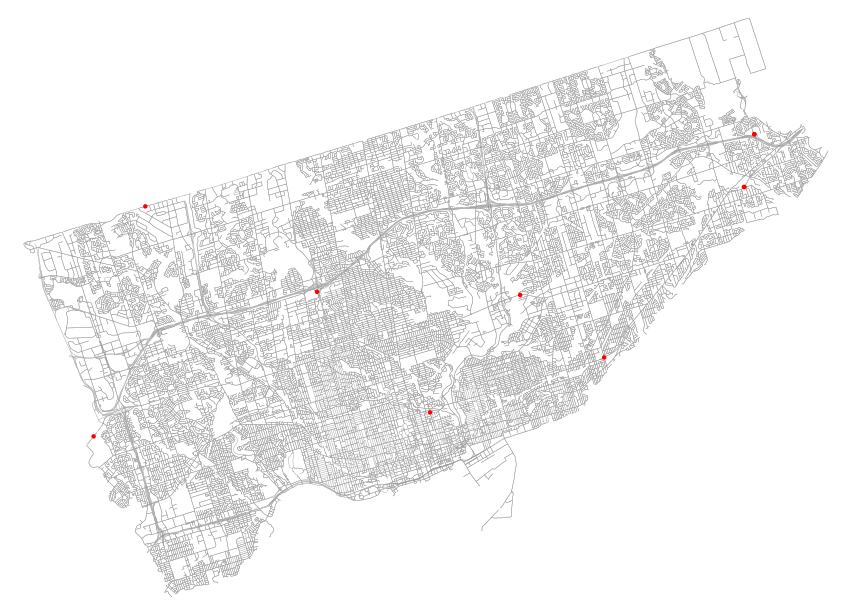

(<Figure size 1080x1080 with 1 Axes>, <AxesSubplot:>)

In [ ]:
glytics.plot_graph(G, list(glytics.pagerank_top_n(G, 10).index.values))

## Routing

In [ ]:
orig = list(G)[8776]
dest = list(G)[17]

In [ ]:
glytics.print_route_time_distance(G, glytics.get_route_by_risk(G, orig, dest))

Route is 32.31 kms and takes 21.50 minutes. This route has a total injury index of:  159


In [ ]:
glytics.print_route_time_distance(G, glytics.get_route_by_time(G, orig, dest))

Route is 26.60 kms and takes 18.15 minutes. This route has a total injury index of:  285


In [ ]:
glytics.print_route_time_distance(G, glytics.get_route_by_length(G, orig, dest))

Route is 24.56 kms and takes 28.30 minutes. This route has a total injury index of:  1156


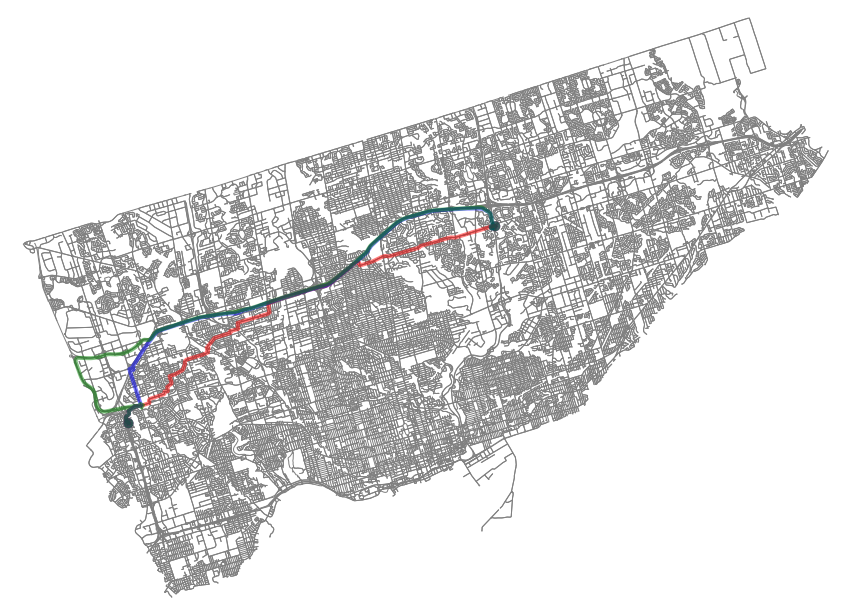

(<Figure size 1080x1080 with 1 Axes>, <AxesSubplot:>)

In [ ]:
glytics.plot_all_routes(G, orig, dest)

## Clustering

In [ ]:
communities = glytics.girvan_newman_upto_k(G, 100)

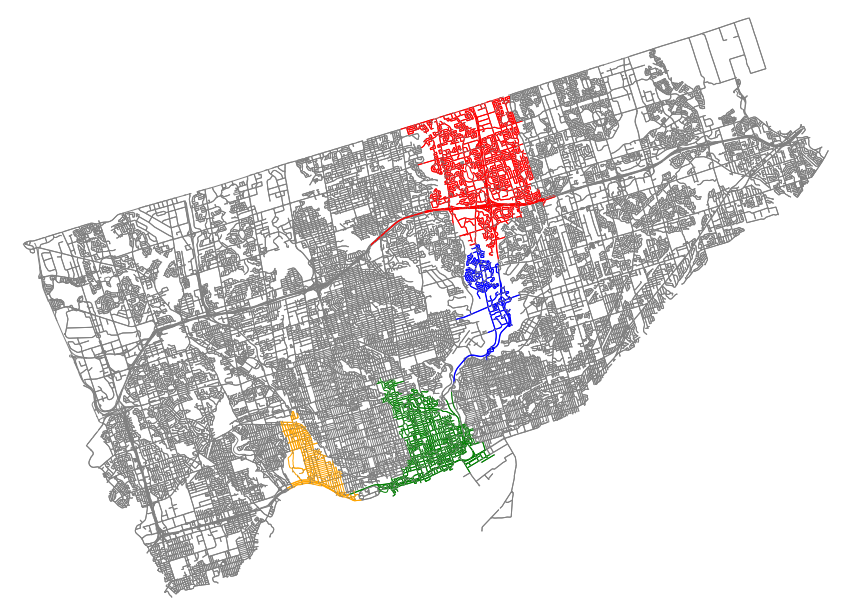

(<Figure size 1080x1080 with 1 Axes>, <AxesSubplot:>)

In [ ]:
glytics.plot_top_4_communities(G, communities)

In [ ]:
glytics.average_injury_index(G, communities[0])

0.22155863073561527

In [ ]:
glytics.average_accident_weight(G, communities[0])

9.085560101765582

In [ ]:
for c in range(4):
  print("===================")
  print(c)
  print(glytics.average_injury_index(G, communities[c]))
  print(glytics.average_accident_weight(G, communities[c]))

0
0.22155863073561527
9.085560101765582
1
0.2900763358778627
10.329708000730943
2
0.6947622884770362
7.969366742211569
3
0.5853260869565218
7.98207787711806
